In [27]:

import os
import glob
import json
import h5py
import optparse
import sys
import traceback
import copy
import datetime

import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
import scipy as sp
import statsmodels as sm
import cPickle as pkl
import tifffile as tf

import numpy as np
from scipy.optimize import leastsq
import pylab as plt


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python.retinotopy import target_visual_field as targ
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra
from pipeline.python.retinotopy import estimate_RF_size as est

In [3]:
%matplotlib notebook

In [14]:
def load_retino_analysis_info(animalid, session, fov, run, retinoid, use_pixels=False, rootdir='/n/coxfs01/2p-data'):
    
    run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
    fov = os.path.split(os.path.split(run_dir)[0])[-1]
    print("FOV: %s, run: %s" % (fov, run))
    retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoids_fpath, 'r') as f:
        rids = json.load(f)
    if use_pixels:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
    else:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
    if retinoid not in roi_analyses:
        retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
        print("Fixed retino id to most recent: %s" % retinoid)
        
    return retinoid, rids[retinoid]


def get_retino_stimulus_info(mwinfo, runinfo):
    
    stiminfo = dict((cond, dict()) for cond in conditions)
    for curr_cond in conditions:
        # get some info from paradigm and run file
        stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
        stimperiod = 1./stimfreq # sec per cycle
        
        n_frames = runinfo['nvolumes']
        fr = runinfo['frame_rate']
        
        n_cycles = int(round((n_frames/fr) / stimperiod))
        #print n_cycles

        n_frames_per_cycle = int(np.floor(stimperiod * fr))
        cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

        stiminfo[curr_cond] = {'stimfreq': stimfreq,
                               'frame_rate': fr,
                               'n_reps': len(trials_by_cond[curr_cond]),
                               'nframes': n_frames,
                               'n_cycles': n_cycles,
                               'n_frames_per_cycle': n_frames_per_cycle,
                               'cycle_start_ixs': cycle_starts
                              }

    return stiminfo


# Interpolate bar position for found SI frame using upsampled MW tstamps and positions:


def get_interp_positions(condname, mwinfo, stiminfo, trials_by_cond):
    mw_fps = 1./np.diff(np.array(mwinfo[str(trials_by_cond[condname][0])]['stiminfo']['tstamps'])/1E6).mean()
    si_fps = stiminfo[condname]['frame_rate']
    print "[%s]: Downsampling MW positions (sampled at %.2fHz) to SI frame rate (%.2fHz)" % (condname, mw_fps, si_fps)

    si_cyc_ixs = stiminfo[condname]['cycle_start_ixs']
    si_tstamps = runinfo['frame_tstamps_sec']


    #fig, axes = pl.subplots(1, len(trials_by_cond[condname]))

    stim_pos_list = []
    stim_tstamp_list = []

    for ti, trial in enumerate(trials_by_cond[condname]):
        #ax = axes[ti]

        pos_list = []
        tstamp_list = []
        mw_cyc_ixs = mwinfo[str(trial)]['stiminfo']['start_indices']
        for cix in np.arange(0, len(mw_cyc_ixs)):
            if cix==len(mw_cyc_ixs)-1:
                mw_ts = [t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:]]
                xs = mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:]
                si_ts = si_tstamps[si_cyc_ixs[cix]:]
            else:
                mw_ts = np.array([t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]]])
                xs = np.array(mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]])
                si_ts = si_tstamps[si_cyc_ixs[cix]:si_cyc_ixs[cix+1]]

            recentered_mw_ts = [t-mw_ts[0] for t in mw_ts]
            recentered_si_ts = [t-si_ts[0] for t in si_ts]

            # Since MW tstamps are linear, SI tstamps linear, interpolate position values down to SI's lower framerate:
            interpos = sp.interpolate.interp1d(recentered_mw_ts, xs, fill_value='extrapolate')
            resampled_xs = interpos(recentered_si_ts)

            pos_list.append(pd.Series(resampled_xs, name=trial))
            tstamp_list.append(pd.Series(recentered_si_ts, name=trial))

            #ax.plot(recentered_mw_ts, xs, 'ro', alpha=0.5, markersize=2)
            #ax.plot(recentered_si_ts, resampled_xs, 'bx', alpha=0.5, markersize=2)

        pos_vals = pd.concat(pos_list, axis=0).reset_index(drop=True) 
        tstamp_vals = pd.concat(tstamp_list, axis=0).reset_index(drop=True)

        stim_pos_list.append(pos_vals)
        stim_tstamp_list.append(tstamp_vals)

    stim_positions = pd.concat(stim_pos_list, axis=1)
    stim_tstamps = pd.concat(stim_tstamp_list, axis=1)


    return stim_positions, stim_tstamps

In [9]:

def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-r', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options


# Select data set

In [10]:

#%%

options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']
#options = ['-i', 'JC070', '-S', '20190314', '-A', 'FOV1']
#options = ['-i', 'JC059', '-S', '20190227', '-A', 'FOV4']

#options = ['-i', 'JC059', '-S', '20190228', '-A', 'FOV1']

#options = ['-i', 'JC073', '-S', '20190321', '-A', 'FOV1', '-R', 'retino_run1']

#options = ['-i', 'JC073', '-S', '20190327', '-A', 'FOV1', '-R', 'retino_run2']


In [11]:
opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2

# Load data set

In [19]:
# Select which retino analysis to use:
use_pixels = False
retinoid, rinfo = load_retino_analysis_info(animalid, session, fov, run, retinoid, 
                                            use_pixels=use_pixels, rootdir=rootdir)

# Create data identifier for figures:
data_identifier = '|'.join([animalid, session, fov, run, retinoid])
print("*** Dataset: %s ***" % data_identifier)

# Get processed retino data:
run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', 'parsed_trials*.json'))[0]
with open(conditions_fpath, 'r') as f:
    mwinfo = json.load(f)
conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                      for cond in conditions)

# Get run info:
runinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
with open(runinfo_fpath, 'r') as f:
    runinfo = json.load(f)
print "---------------------------------"
print "Trials by condN:", trials_by_cond

# Get stimulus info:
stiminfo = get_retino_stimulus_info(mwinfo, runinfo)
stiminfo['trials_by_cond'] = trials_by_cond

# Load raw traces -- Use 'processed' (np-corrected + preprocessing)
extracted_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.h5'))[0]
extr_traces = h5py.File(extracted_traces_fpath)
print 'Extracted retino traces contains:' 
print '---', extr_traces.keys()
print 'Each parsed file contains:'
print "--- ---", extr_traces[extr_traces.keys()[0]].keys()

print "---------------------------------"
print "Current retino run: %s" % run
print "---------------------------------"
for param in stiminfo['right'].keys():
    if param == 'cycle_start_ixs': continue
    print param, ':', stiminfo['right'][param]

FOV: FOV1_zoom4p0x, run: retino_run1
*** Dataset: JC047|20190215|FOV1|retino_run1|analysis002 ***
Found 12 processed retino runs.
---------------------------------
Trials by condN: {u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
Extracted retino traces contains:
--- [u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010', u'File011', u'File012']
Each parsed file contains:
--- --- [u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
---------------------------------
Current retino run: retino_run1
---------------------------------
nframes : 4125
n_cycles : 12
stimfreq : 0.13
frame_rate : 44.6329
n_reps : 3
n_frames_per_cycle : 343


# Get bar positions (MW) and corresponding phase data (SI):

In [20]:
print "-----------------------------------"
print "Getting MW info (stimulus positions)"
stim_positions = dict()
stim_tstamps = dict()
for cond in trials_by_cond.keys():
    stim_positions[cond], stim_tstamps[cond] = get_interp_positions(cond, mwinfo, stiminfo, trials_by_cond)

print "Stimulus conditions (bar start/end):"
for cond in stim_positions.keys():
    print '--- %s: [%.2f, %.2f]' %(cond, stim_positions[cond].iloc[0,:].mean(), stim_positions[cond].iloc[-1,:].mean())



# Get FFT results and format
print "-----------------------------------"
print "Getting formatted FFT analysis"
fit, magratio, phase, trials_by_cond = targ.trials_to_dataframes(processed_fpaths, conditions_fpath)

print "-----------------------------------"
print "Getting screen info"
screen_info = visroi.get_screen_info(animalid, session, fov=fov.split('_')[0], interactive=True, rootdir=rootdir)


-----------------------------------
Getting MW info (stimulus positions)
[top]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[right]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[left]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[bottom]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
Stimulus conditions (bar start/end):
--- top: [43.72, -50.11]
--- right: [43.72, -49.83]
--- bottom: [-43.72, 49.94]
--- left: [-43.72, 49.86]
-----------------------------------
Getting formatted FFT analysis
TRIALS BY COND:
{u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
Trials: [11, 10, 12, 1, 3, 2, 5, 4, 7, 6, 9, 8]
1: retino_data_FOV1_retino_Slice01_Channel01_File001.h5
2: retino_data_FOV1_retino_Slice01_Channel01_File002.h5
3: retino_data_FOV1_retino_Slice01_Channel01_File003.h5
4: retino_data_FOV1_retino_Slice01_Channel01_File004.h5
5: retino_dat

In [22]:
print processed_fpaths[0]
# Comine all trial data into data frames:
fit, magratio, phase, trials_by_cond = targ.trials_to_dataframes(processed_fpaths, conditions_fpath)
#print fit.head()
print trials_by_cond

/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/files/retino_data_FOV1_retino_Slice01_Channel01_File001.h5
TRIALS BY COND:
{u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
Trials: [11, 10, 12, 1, 3, 2, 5, 4, 7, 6, 9, 8]
1: retino_data_FOV1_retino_Slice01_Channel01_File001.h5
2: retino_data_FOV1_retino_Slice01_Channel01_File002.h5
3: retino_data_FOV1_retino_Slice01_Channel01_File003.h5
4: retino_data_FOV1_retino_Slice01_Channel01_File004.h5
5: retino_data_FOV1_retino_Slice01_Channel01_File005.h5
6: retino_data_FOV1_retino_Slice01_Channel01_File006.h5
7: retino_data_FOV1_retino_Slice01_Channel01_File007.h5
8: retino_data_FOV1_retino_Slice01_Channel01_File008.h5
9: retino_data_FOV1_retino_Slice01_Channel01_File009.h5
10: retino_data_FOV1_retino_Slice01_Channel01_File010.h5
11: retino_data_FOV1_retino_Slice01_Channel01_File011.h5
12: retino_data_FOV1_retino_Slice01_Channel01_File012.h5
{u'top': [11, 5, 6], 

# Set output dir for fit results

In [28]:
datestr = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

output_dir = os.path.join(processed_dir, 'visualization', 'fits', datestr)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Saving fit results to: %s" % output_dir)

Saving fit results to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/fits/20190402112631


# Select ROIs for analysis

In [32]:
# Convert phase info to absolute coords
mag_thr = magratio.mean(axis=1).max() * 0.2 #0.02
delay_thr = np.pi #/ 2.
absolute_coords = targ.get_absolute_centers(phase, magratio, trials_by_cond, stim_positions, \
                                            equal_travel_lengths=True, absolute=True,
                                            mag_thr=mag_thr, delay_thr=delay_thr)
# Also get mean magratios:
mean_magratios = pd.concat([pd.Series(magratio[trialnums].mean(axis=1), name=cond) \
                            for cond, trialnums in trials_by_cond.items()], axis=1)
print mean_magratios.shape
mean_magratios.head()

('ROIs with best mag-ratio (n=58, thr=0.02):', [3, 5, 12, 13, 14, 15, 17, 18, 19, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 45, 46, 47, 49, 53, 54, 55, 58, 60, 61, 62, 63, 64, 65, 68, 72, 76, 77, 79, 80, 81, 82, 83, 91, 96, 97, 98, 100, 101, 102, 104, 106, 107])
[AZ] Average delay (std): -0.29 (0.86)
[EL] Average delay (std): 0.52 (1.53)
(108, 4)


top     right      left    bottom
0  0.005262  0.009136  0.003781  0.005904
1  0.005768  0.009894  0.007314  0.008743
2  0.004250  0.005627  0.005135  0.004913
3  0.072648  0.050793  0.050863  0.057089
4  0.008493  0.013418  0.011699  0.013822

In [33]:
mag_thr = magratio.mean(axis=1).max() * 0.2 #0.02
use_fit = False

if use_fit:
    print 'LinX min/max found:', absolute_coords['linX'].min(), absolute_coords['linX'].max()
    print 'LinY min/max found:', absolute_coords['linY'].min(), absolute_coords['linY'].max()

    [bottom_pos, left_pos, top_pos, right_pos] = absolute_coords['screen_bb']

    top_rois = np.array(absolute_coords['strong_cells'])
    mag_thr = absolute_coords['mag_thr']
    
else:
    best_mags = mean_magratios.loc[mean_magratios.mean(axis=1)>mag_thr].index.tolist()
    top_rois = copy.copy(np.array(best_mags))
                         

print "-----------------------------------"
if use_fit: 
    print "Filtering ROIs by best fit."
else:
    print "Filtering ROIs by strongest mag-ratios."
print "Strongest cells (n=%i, mag-ratio >= %.2f):" % (len(top_rois), mag_thr)
print top_rois                   
print "-----------------------------------"


-----------------------------------
Filtering ROIs by strongest mag-ratios.
Strongest cells (n=58, mag-ratio >= 0.02):
[  3   5  12  13  14  15  17  18  19  23  24  26  27  28  29  30  31  32
  33  34  36  37  38  39  42  45  46  47  49  53  54  55  58  60  61  62
  63  64  65  68  72  76  77  79  80  81  82  83  91  96  97  98 100 101
 102 104 106 107]
-----------------------------------


# Visualize raw data

#### Load traces averaged by condition:

In [139]:
# This file gets created with visualization/get_session_summary() when estimate_RF_size.py is used

avg_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.pkl'))
if len(avg_traces_fpath) == 0:
    print "Getting averaged ROI traces by cond and estimating RFs..."
    # Need to run estimate_RF_size.py:
    est.estimate_RFs_and_plot(['-i', animalid,'-S', session, '-A', fov, '-R', run, '-r', retinoid])
    avg_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.pkl'))[0]
else:
    avg_traces_fpath = avg_traces_fpath[0]
    
print("Loading pre-averaged traces from: %s" % avg_traces_fpath)

with open(avg_traces_fpath, 'rb') as f:
    traces = pkl.load(f)
print("averaged_traces.pkl contains:", traces.keys())

# trials_by_cond = traces['conditions']
# print("Conditions (by rep):", trials_by_cond)

print "Cond dict:", traces['traces']['right']

Loading pre-averaged traces from: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/traces/averaged_roi_traces.pkl
('averaged_traces.pkl contains:', ['source_tifs', 'traces', 'RETINOID', 'masks', 'mwinfo', 'conditions'])
Cond dict: {'info': {'stimulus': u'right', 'stimfreq': 0.13, 'frame_rate': 44.6329, 'n_reps': 3}, 'traces': array([[  3.79618043e+00,   3.65672880e+00,   3.75006778e+00, ...,
          2.42589203e+00,   5.22900404e-01,  -1.12550637e+00],
       [ -5.46177363e+00,  -4.25502803e+00,  -5.06569435e+00, ...,
         -3.04327511e-01,  -3.43201620e+00,  -3.24832549e+00],
       [  1.71320712e+00,   2.19038241e+00,   2.09775858e-03, ...,
         -3.51555743e+00,  -2.72986144e+00,  -4.17969142e-01],
       ..., 
       [  9.46756677e+00,   4.26263107e+00,   2.26369001e+00, ...,
         -1.74497523e+00,  -1.34530110e+00,  -1.40808100e+00],
       [ -8.16790348e+00,  -1.22812778e+01,  -1.83349096e+01, ...,
          1.72754919e+01, 

In [112]:
from matplotlib.lines import Line2D
from matplotlib.legend import Legend


#### Visualize average timecourses of "strongest" cells

In [140]:

def plot_roi_traces_by_condition(rid, traces, stiminfo, plot_best_worst=False, c1_color='b', c2_color='orange',
                                c_best=None, c_worst=None):
    
    fig, axes = pl.subplots(1, 2, figsize=(8,3))
    for ai, (c1, c2) in enumerate([('left', 'right'), ('top', 'bottom')]):
        ax = axes[ai]

        if plot_best_worst:
            assert (c_best is not None and c_worst is not None), "** Don't know which are best/worst condns!"
            if c1 == c_best:
                c1_color = 'r'
            elif c1 == c_worst:
                c1_color = 'b'
            else:
                c1_color = 'k'

            if c2 == c_best:
                c2_color = 'r'
            elif c2 == c_worst:
                c2_color = 'b'
            else:
                c2_color = 'k'

            if c1_color == c2_color:
                c1_color = 'magenta'
                c2_color = 'green'
                
        ax.plot(traces['traces'][c1]['traces'][rid, :], c1_color, lw=0.5, label=c1)
        ax.plot(traces['traces'][c2]['traces'][rid, :], c2_color, lw=0.5, label=c2)
        ax.set_xlabel('frame')
        for cyc1, cyc2 in zip(stiminfo[c1]['cycle_start_ixs'], stiminfo[c2]['cycle_start_ixs']):
            ax.axvline(x=cyc1, color='k', lw=0.5, linestyle='--', alpha=0.3)
            ax.axvline(x=cyc2, color='k', lw=0.5, linestyle='--', alpha=0.3)
        ax.legend(loc='upper right', bbox_to_anchor=(1.32, 1), fontsize=8)
        sns.despine(offset=4, trim=True, ax=ax)

    custom_lines = [Line2D([0], [0], color='r', lw=.5),
                    Line2D([0], [0], color='b', lw=.5)]
    leg2 = Legend(ax, custom_lines, ['best', 'worst'], loc='upper right', bbox_to_anchor=(1.29, 0.55), fontsize=8)
    ax.add_artist(leg2)

    fig.subplots_adjust(right=0.8, top=0.7, bottom=0.3, left=0.05, wspace=0.6)
    
    return fig


#### Test with single roi

<IPython.core.display.Javascript object>


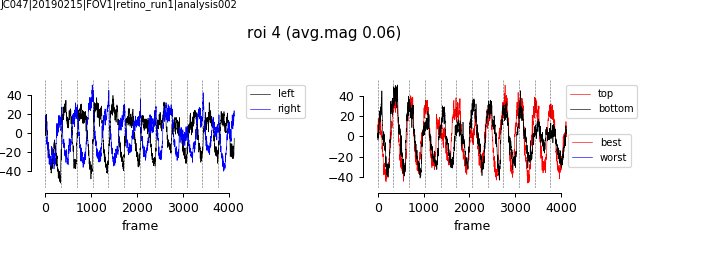

/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/fits/20190402112631


In [142]:
rid = top_rois[0]

plot_best_worst = True
c1_color = 'b'
c2_color = 'orange'

c_best = mean_magratios.iloc[rid][mean_magratios.iloc[rid]==mean_magratios.iloc[rid].max()].index[0]
c_worst = mean_magratios.iloc[rid][mean_magratios.iloc[rid]==mean_magratios.iloc[rid].min()].index[0]
rid_mean_mag = mean_magratios.iloc[rid].mean()

fig = plot_roi_traces_by_condition(rid, traces, stiminfo, plot_best_worst=plot_best_worst,
                                   c_best=c_best, c_worst=c_worst,
                                   c1_color=c1_color, c2_color=c2_color)
fig.suptitle('roi %i (avg.mag %.2f)' % (int(rid+1), rid_mean_mag), y=0.9, x=0.45)
label_figure(fig, data_identifier)

print output_dir

#### Now, plot all selected ROIs

<IPython.core.display.Javascript object>


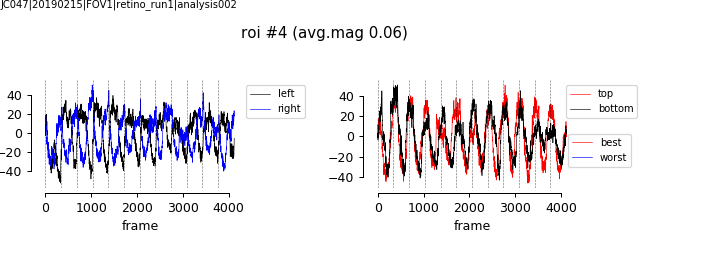

<IPython.core.display.Javascript object>


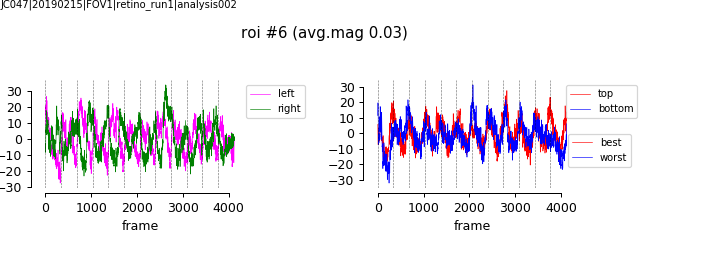

<IPython.core.display.Javascript object>


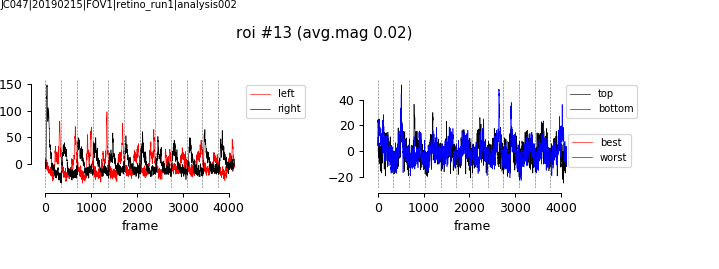

<IPython.core.display.Javascript object>


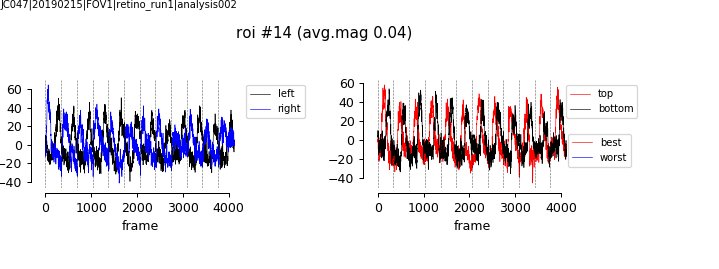

<IPython.core.display.Javascript object>


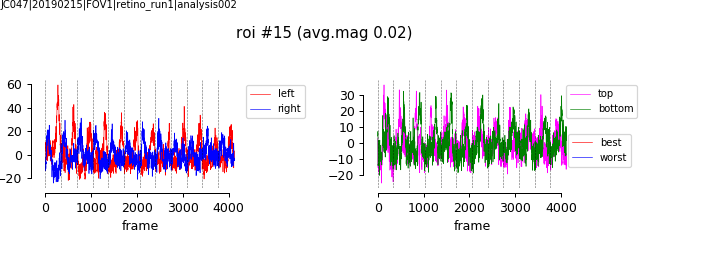

<IPython.core.display.Javascript object>


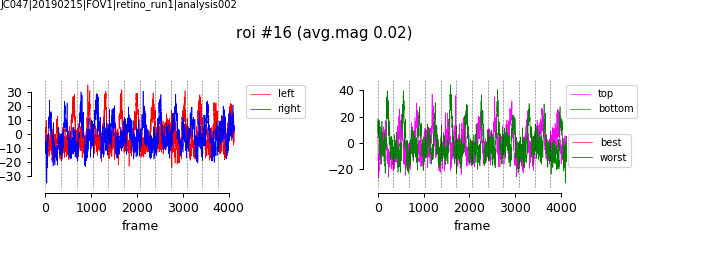

<IPython.core.display.Javascript object>


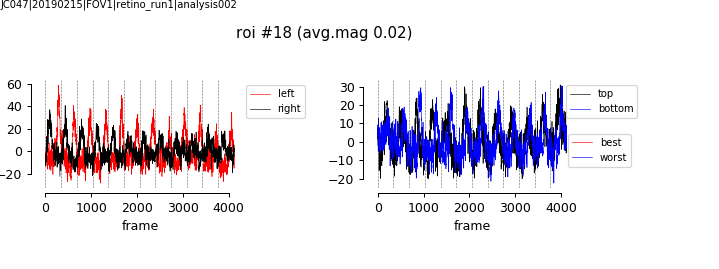

<IPython.core.display.Javascript object>


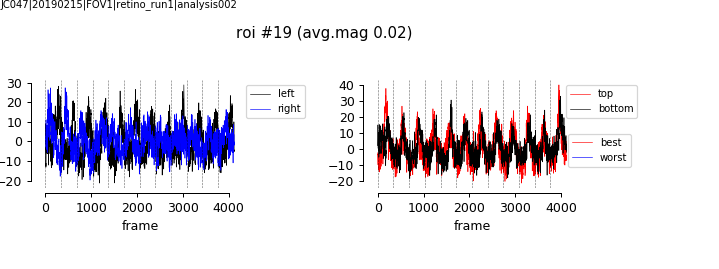

<IPython.core.display.Javascript object>


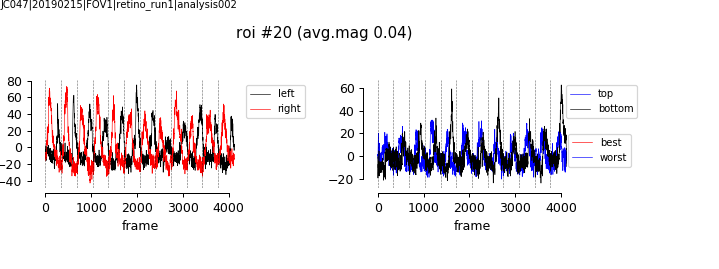

<IPython.core.display.Javascript object>


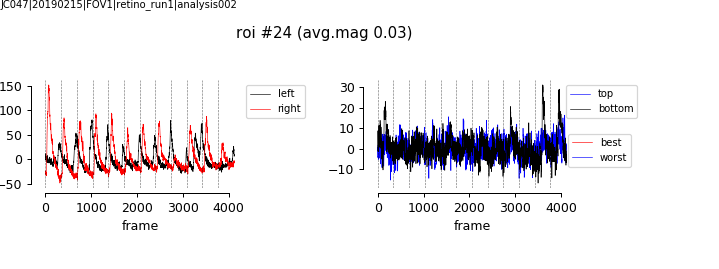

<IPython.core.display.Javascript object>


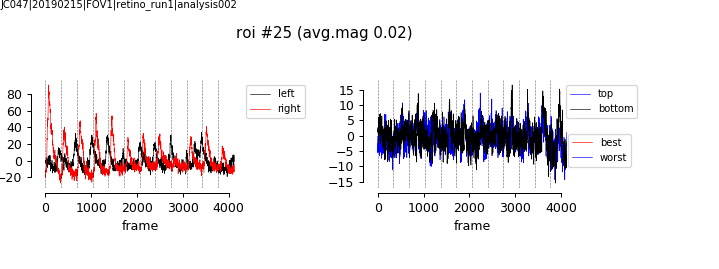

<IPython.core.display.Javascript object>


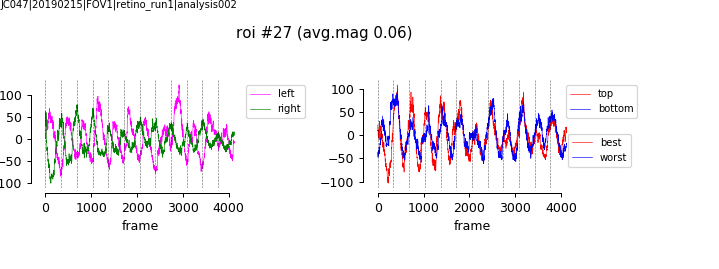

<IPython.core.display.Javascript object>


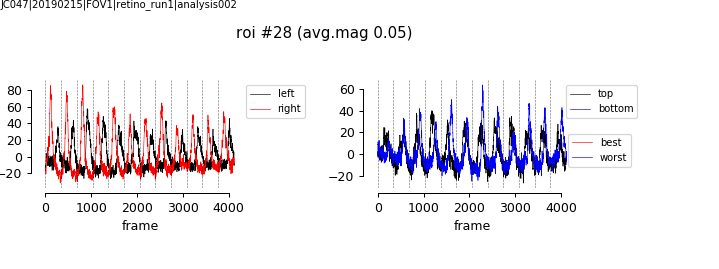

<IPython.core.display.Javascript object>


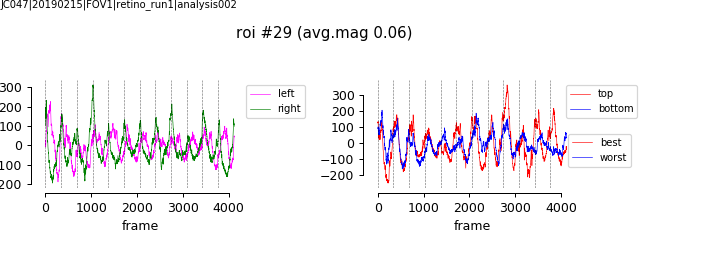

<IPython.core.display.Javascript object>


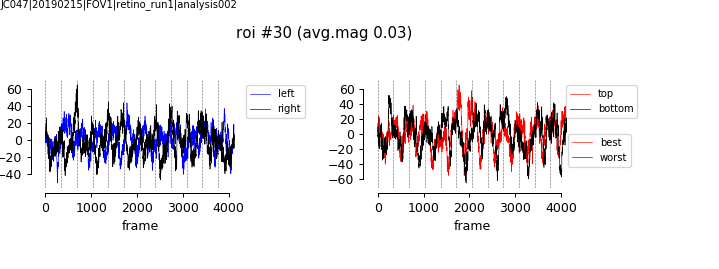

<IPython.core.display.Javascript object>


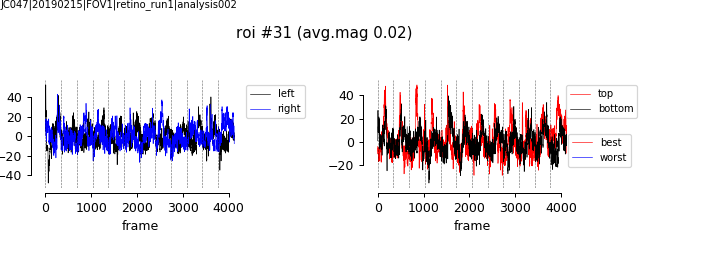

<IPython.core.display.Javascript object>


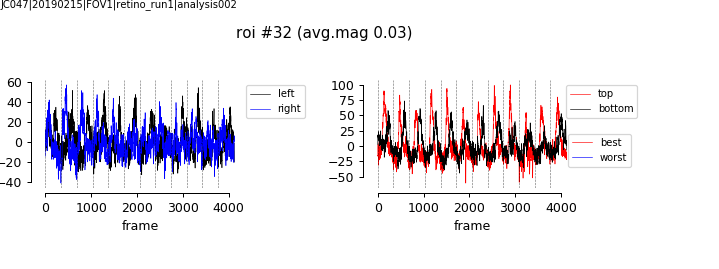

<IPython.core.display.Javascript object>


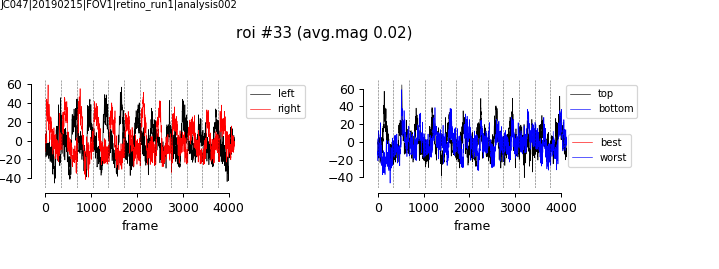

<IPython.core.display.Javascript object>


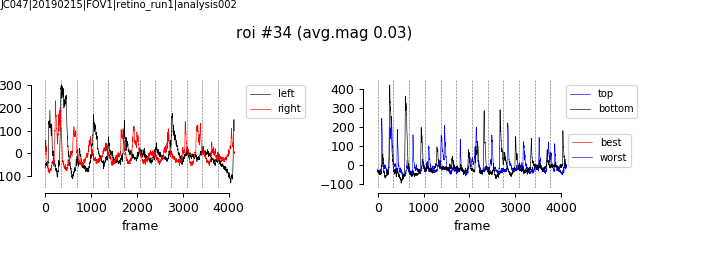

<IPython.core.display.Javascript object>


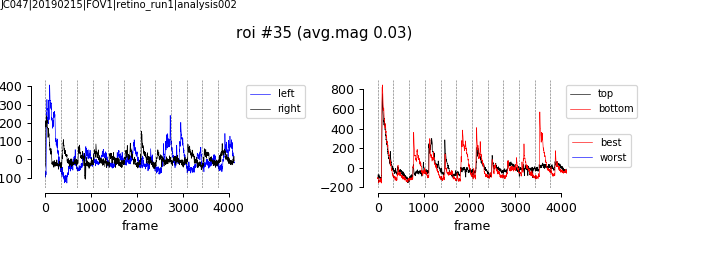

<IPython.core.display.Javascript object>


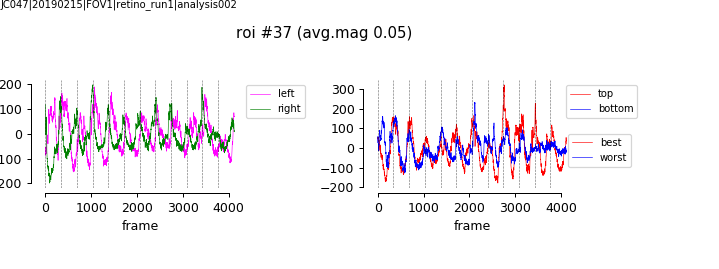

<IPython.core.display.Javascript object>


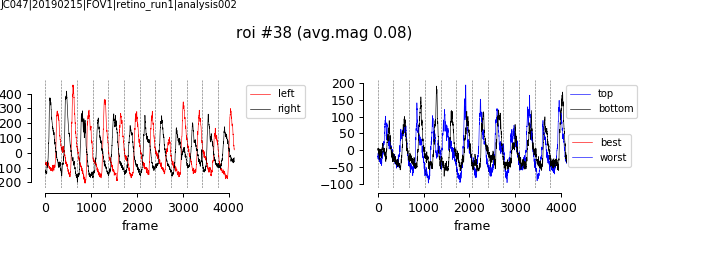

<IPython.core.display.Javascript object>


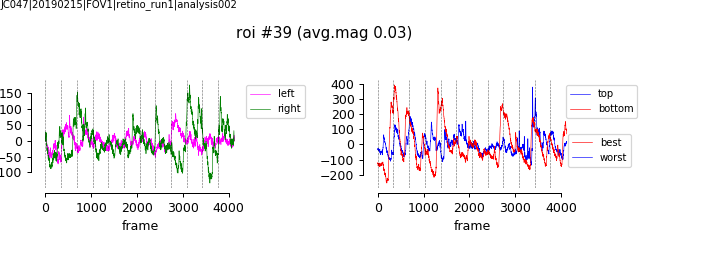

<IPython.core.display.Javascript object>


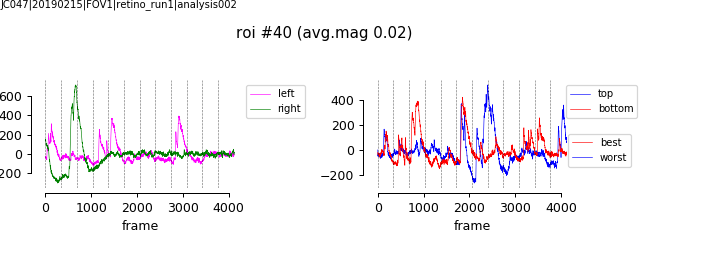

<IPython.core.display.Javascript object>


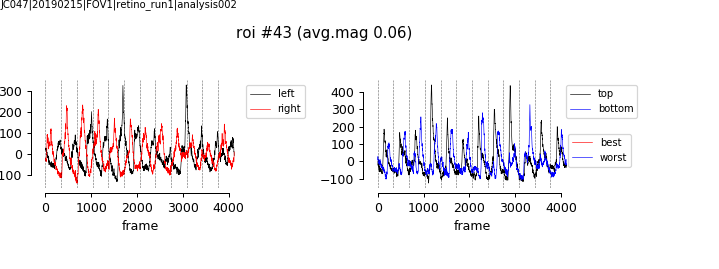

<IPython.core.display.Javascript object>


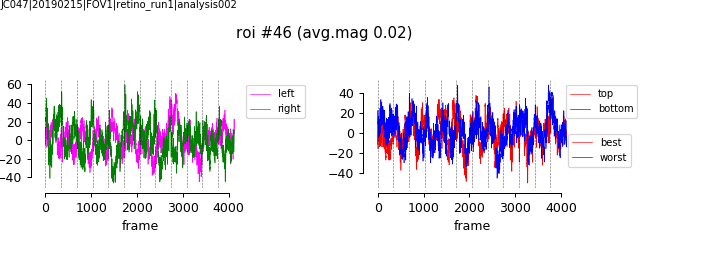

<IPython.core.display.Javascript object>


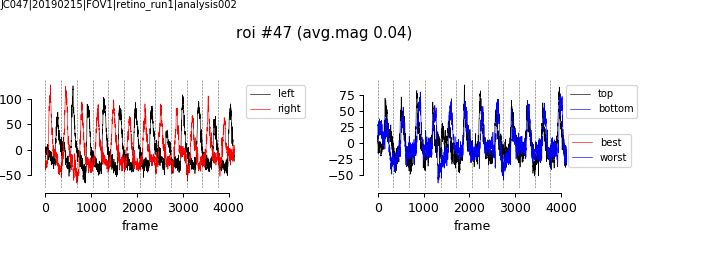

<IPython.core.display.Javascript object>


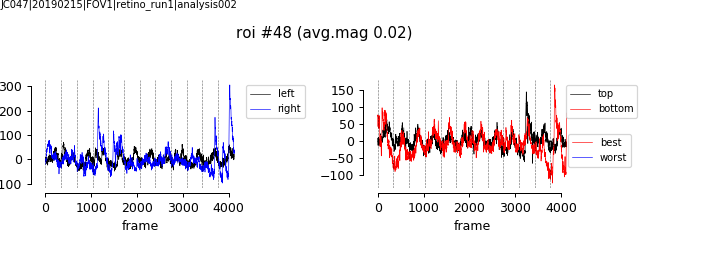

<IPython.core.display.Javascript object>


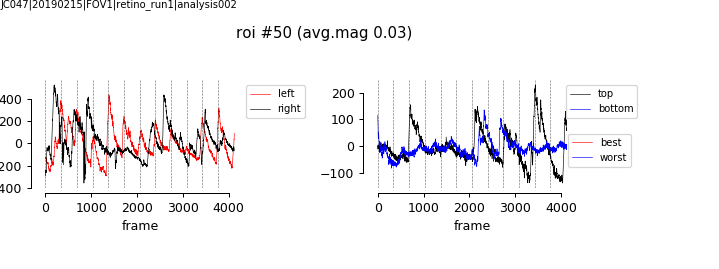

<IPython.core.display.Javascript object>


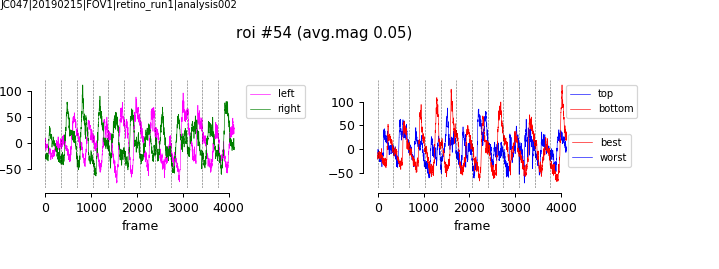

<IPython.core.display.Javascript object>


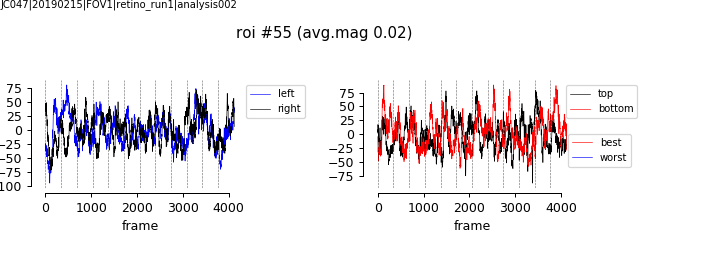

<IPython.core.display.Javascript object>


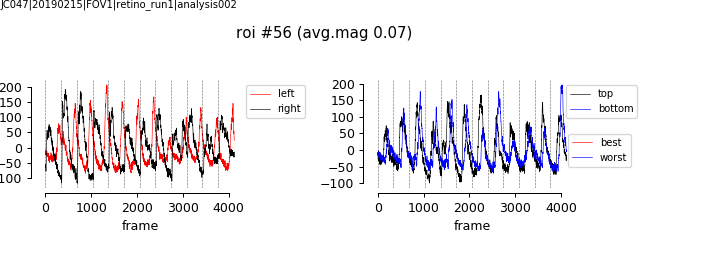

<IPython.core.display.Javascript object>


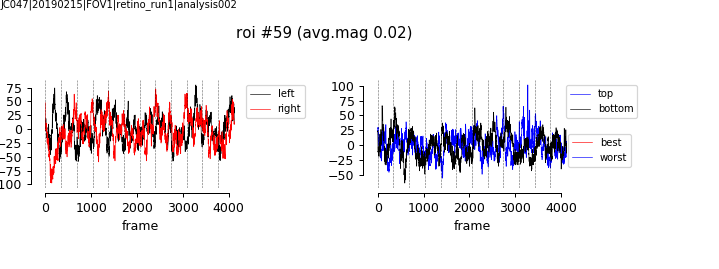

<IPython.core.display.Javascript object>


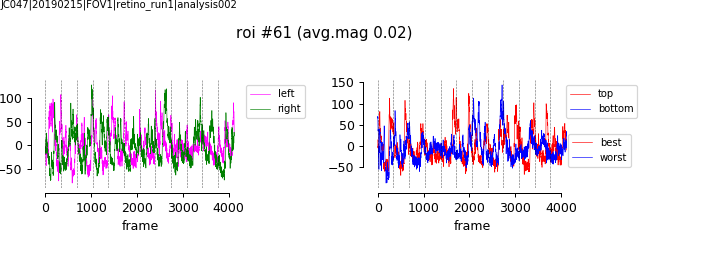

<IPython.core.display.Javascript object>


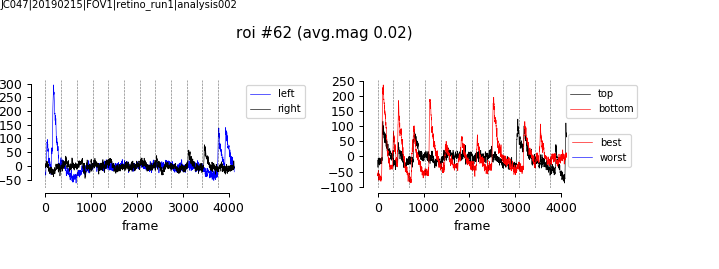

<IPython.core.display.Javascript object>


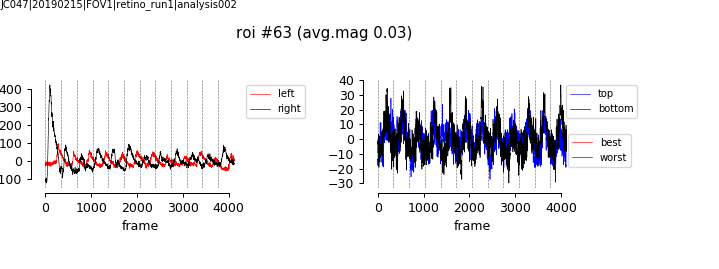

<IPython.core.display.Javascript object>


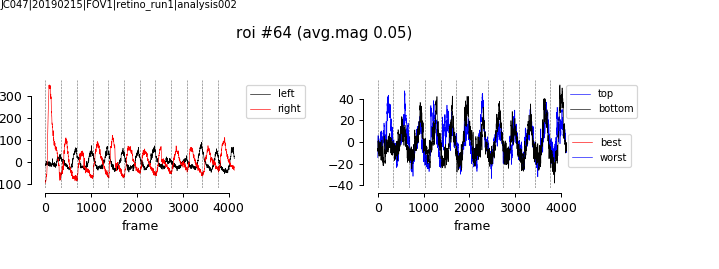

<IPython.core.display.Javascript object>


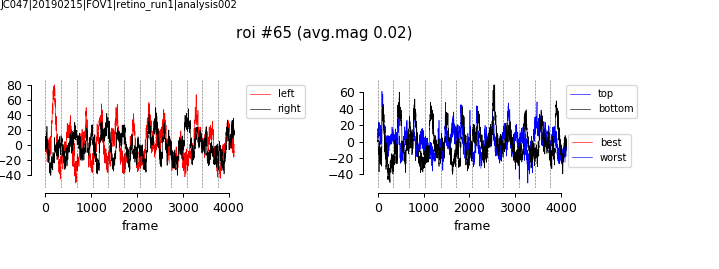

<IPython.core.display.Javascript object>


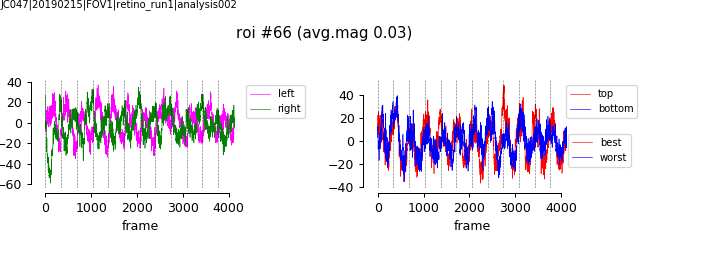

<IPython.core.display.Javascript object>


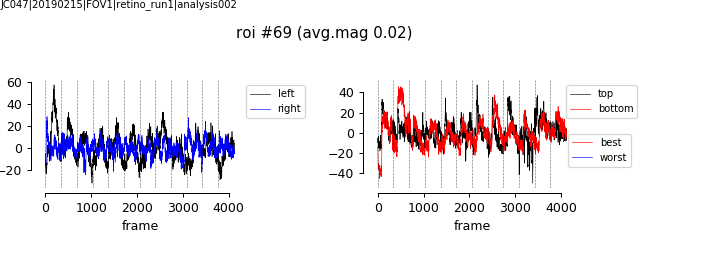

<IPython.core.display.Javascript object>


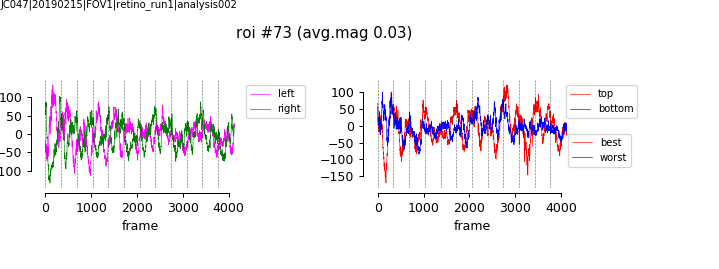

<IPython.core.display.Javascript object>


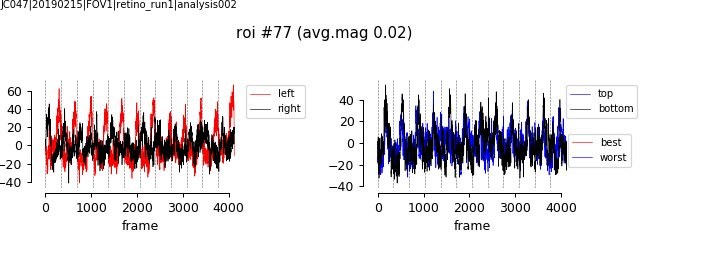

<IPython.core.display.Javascript object>


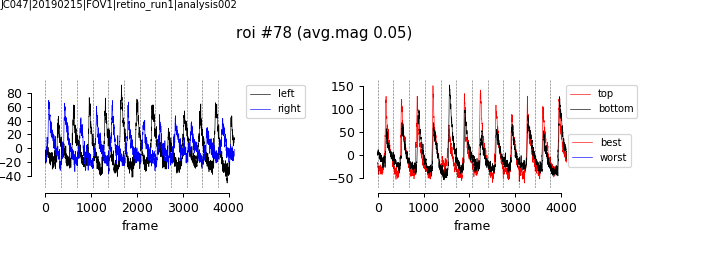

<IPython.core.display.Javascript object>


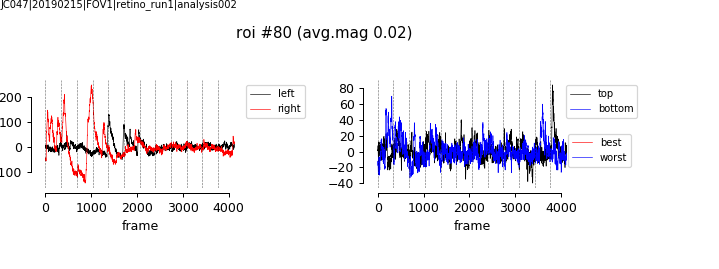

<IPython.core.display.Javascript object>


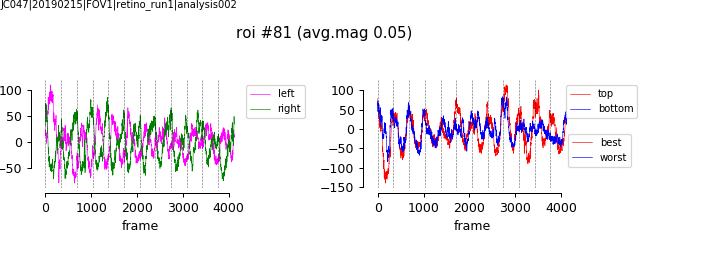

<IPython.core.display.Javascript object>


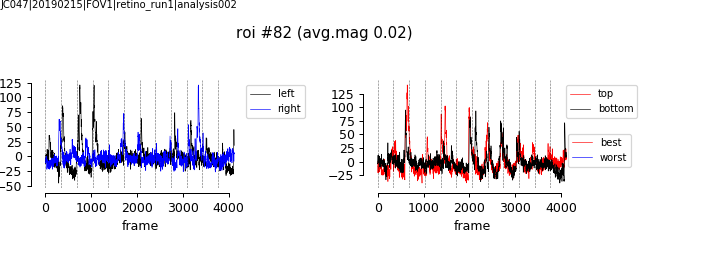

<IPython.core.display.Javascript object>


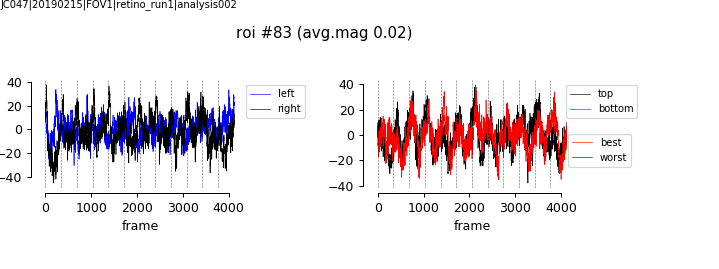

<IPython.core.display.Javascript object>


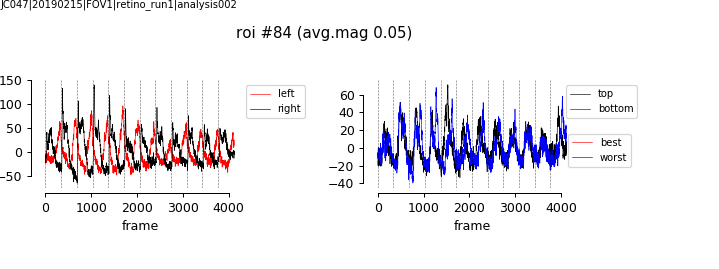

<IPython.core.display.Javascript object>


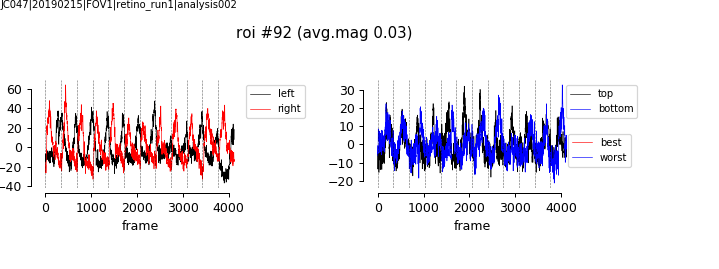

<IPython.core.display.Javascript object>


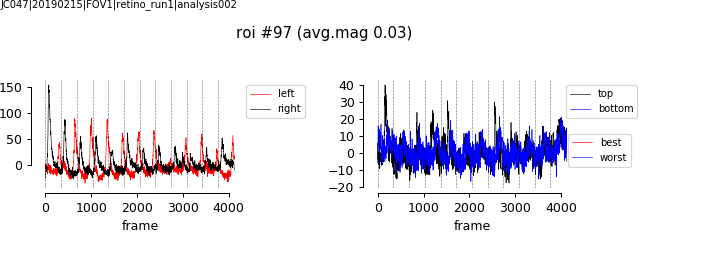

<IPython.core.display.Javascript object>


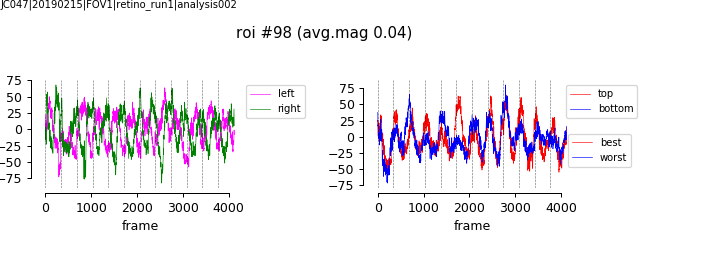

<IPython.core.display.Javascript object>


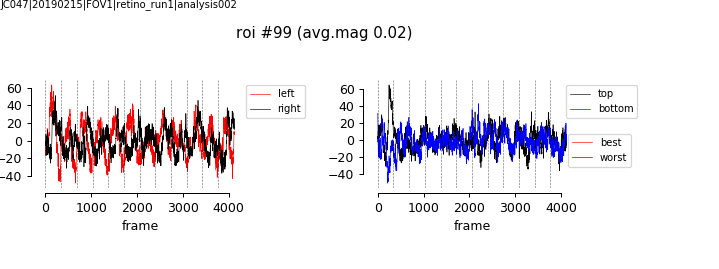

<IPython.core.display.Javascript object>


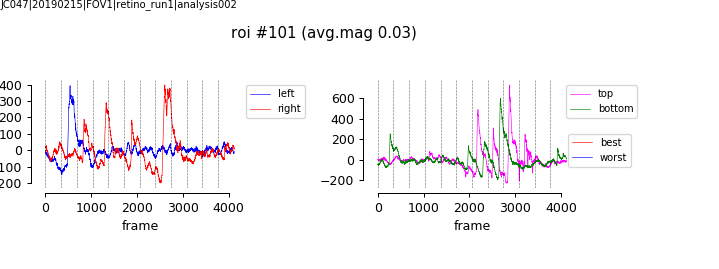

<IPython.core.display.Javascript object>


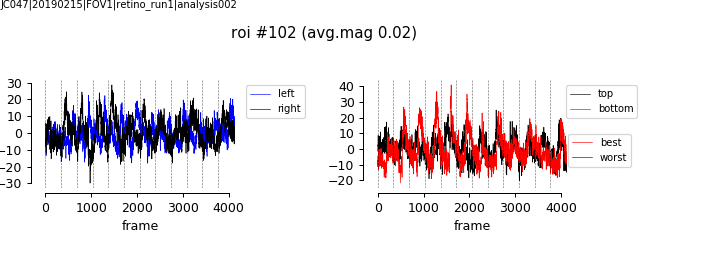

<IPython.core.display.Javascript object>


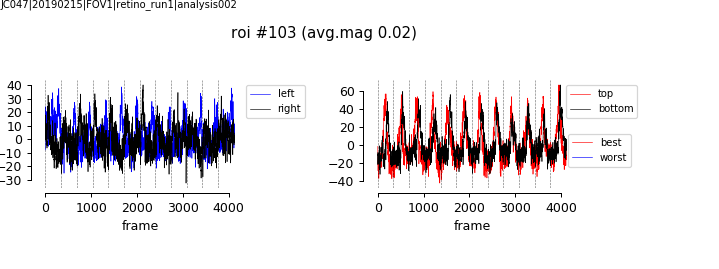

<IPython.core.display.Javascript object>


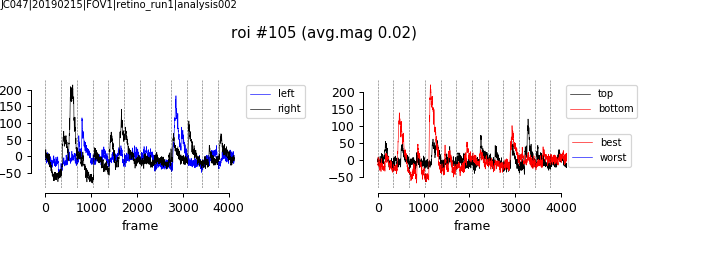

<IPython.core.display.Javascript object>


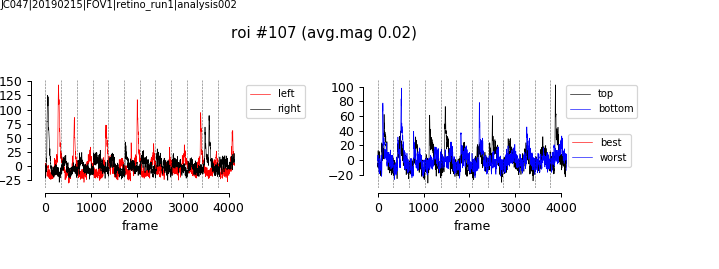

<IPython.core.display.Javascript object>


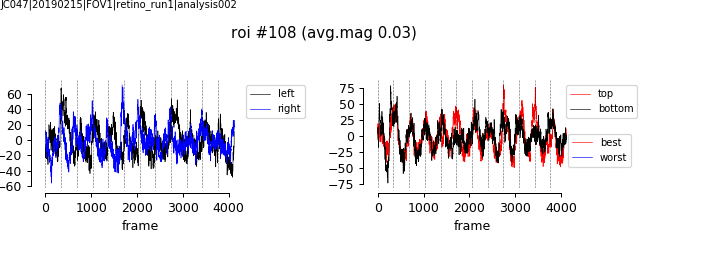

In [143]:

plot_best_worst = True

#fig, ax = pl.subplots(len(best_fits), 1, figsize=(5, len(best_fits)*2), sharex=True) #pl.figure()
curr_figdir = os.path.join(output_dir, 'roi_traces')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)

for ri,rid in enumerate(top_rois):

    c_best = mean_magratios.iloc[rid][mean_magratios.iloc[rid]==mean_magratios.iloc[rid].max()].index[0]
    c_worst = mean_magratios.iloc[rid][mean_magratios.iloc[rid]==mean_magratios.iloc[rid].min()].index[0]
    rid_mean_mag = mean_magratios.iloc[rid].mean()

    fig = plot_roi_traces_by_condition(rid, traces, stiminfo, plot_best_worst=plot_best_worst,
                                       c_best=c_best, c_worst=c_worst,
                                       c1_color=c1_color, c2_color=c2_color)
    fig.suptitle('roi #%i (avg.mag %.2f)' % (int(rid+1), rid_mean_mag), y=0.9, x=0.45)

    label_figure(fig, data_identifier)
    pl.savefig(os.path.join(curr_figdir, 'mean_traces_roi%05d.png' % int(rid+1)))

    

# Fit sinusoid to averaged raw traces

In [170]:

#### Redo regression on average roi trace 
# Get average across reps of condition)


def lst_sq_fit(data, t, init_phase=0, init_freq=1, init_amp=1, use_cos=True):
    init_mean = np.mean(data)
    init_std = 3*np.std(data)/(2**0.5)/(2**0.5)
    #guess_phase = sp.stats.circmean(corrected_phase[trials_by_cond[cond]].iloc[rid]) #0
    #guess_freq = 1 #1 #1
    #guess_amp = np.max(data) #1

    # we'll use this to plot our first estimate. This might already be good enough for you
    if use_cos:
        data_first_guess = init_std * np.cos(t+init_phase) + init_mean
        optimize_func = lambda x: x[0]*np.cos(x[1]*t+x[2]) + x[3] - data
    else:
        data_first_guess = init_std * np.sin(t+init_phase) + init_mean
        optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data


    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    fit_amp, fit_freq, fit_phase, fit_mean = leastsq(optimize_func, [init_amp, init_freq, init_phase, init_mean])[0]

    # recreate the fitted curve using the optimized parameters
    if use_cos:
        data_fit = fit_amp*np.cos(fit_freq * t + fit_phase) + fit_mean
    else:
        data_fit = fit_amp*np.sin(fit_freq * t + fit_phase) + fit_mean

    params =  {'init_phase': init_phase,
              'init_amp': init_amp,
              'init_freq': init_freq,
              'fit_phase': fit_phase,
              'fit_amp': fit_amp,
              'fit_freq': fit_freq,
              'fit_mean': fit_mean,
              't': t}
    
    return data_fit, params #est_amp, est_freq, est_phase, est_mean



def fit_roi_trace(roi_data, roi_phases, t, use_cos=True): #, guess_phase=0, guess_freq=1, guess_amp=1):
    conditions = roi_data.columns.tolist()
    print conditions
    fit_results = {}
    for cond in conditions:
        print("fitting... %s" % cond)
        data = roi_data[cond].values #3.0*np.sin(f*t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise
        init_phase = roi_phases[cond].values
        init_amp = np.max(data)
        init_freq = 1
        data_fit, params = lst_sq_fit(data, t, use_cos=use_cos, init_phase=init_phase, init_freq=init_freq, init_amp=init_amp)
        
        fit_results[cond] = {'fit': data_fit, 'params': params}
        
    return fit_results


def plot_fit_by_condition(fit_results, data=None, t=None, color='k', fit_color=None, label='label', ax=None, annot_loc=0):
    if ax is None:
        fig, ax = pl.subplots()

    #fig, ax = pl.subplots(1, 2, figsize=(15,5)) # = pl.figure()
    if t is not None and data is not None:
        ax.plot(t, data, color=color, lw=0.5, alpha=0.7)
    
    if fit_color is None:
        fit_color = color
    #data_fit = fit_results['fit_amp'] * np.sin(fit_results['fit_freq'] * fit_t + fit_results['fit_phase']) + fit_results['fit_mean']
    data_fit = fit_results['fit']
    ax.plot(fit_results['params']['t'], data_fit, color=fit_color, label=label)
    
    cond_str = "[%s] True: %.2f, Est: %.2f" % (label, fit_results['params']['init_phase'], fit_results['params']['fit_phase'])
    ax.text(ax.get_xlim()[0], annot_loc, cond_str) #ax.get_ylim()[-1]-100, cond_str)
    ax.legend(loc='lower right')


In [171]:

def fit_traces_by_roi(traces, roi_list, trials_by_cond, t=None):

    fit_results = {}

    for rid in roi_list:

        roi_data = pd.concat((pd.Series(data=traces['traces'][cond]['traces'][rid, :], name=cond)\
                              for cond in trials_by_cond.keys()), axis=1)
        roi_phases = pd.DataFrame((pd.Series(data=sp.stats.circmean(phase_array[trialnums].iloc[rid], 
                                                                    high=highval, low=lowval), 
                                             name=cond)) for cond, trialnums in trials_by_cond.items()).T

        roi_fit = fit_roi_trace(roi_data, roi_phases, t, use_cos=use_cos)

        # PLOT ------------------------------------------------------------
        fig, ax = pl.subplots(1, 2, figsize=(15,5)) 


        # Azimuth conditions:
        maxloc = max([roi_data['right'].max(), roi_data['left'].max()])
        plot_fit_by_condition(roi_fit['right'], data=roi_data['right'], t=t, 
                              color='r', label='right', ax=ax[0], annot_loc=maxloc)
        annot_offset = np.diff(ax[0].get_yticks()).mean() * 0.5
        plot_fit_by_condition(roi_fit['left'], data=roi_data['left'], t=t, 
                              color='b', label='left', ax=ax[0],  annot_loc=maxloc-annot_offset) #maxloc-300)

        # Elevation conditions:
        maxloc = max([roi_data['top'].max(), roi_data['bottom'].max()])
        plot_fit_by_condition(roi_fit['top'], data=roi_data['top'], t=t, 
                              color='r', label='top', ax=ax[1], annot_loc=maxloc)
        plot_fit_by_condition(roi_fit['bottom'], data=roi_data['bottom'], t=t, 
                              color='b', label='bottom', ax=ax[1], annot_loc=maxloc-annot_offset) #maxloc-300)
        sns.despine(trim=True, offset=8)
        fig.suptitle('roi %i' % int(rid+1))
        label_figure(fig, data_identifier)

        pl.savefig(os.path.join(curr_figdir, 'lst_sq_fits_roi%05d.png' % int(rid+1)))
        pl.close()

        fit_results[rid] = {'roi_fit': roi_fit,
                             'roi_data': roi_data,
                             'roi_phases': roi_phases,
                             'use_cos': use_cos,
                             'use_corretected': use_corrected}

    return fit_results

In [172]:
# Set params

use_cos = True
use_corrected = False
if use_corrected:
    highval = 2*np.pi # np.pi
    lowval = 0 #-np.pi
    phase_array = corrected_phase.copy()
else:
    highval = np.pi
    lowval = -np.pi
    phase_array = phase.copy()
    

In [173]:
cond = 'left'
stimfreq = traces['traces'][cond]['info']['stimfreq']
fr = traces['traces'][cond]['info']['frame_rate']
nframes = traces['traces'][cond]['traces'].shape[-1]
frame_period = 1./fr
t_frames = np.arange(frame_period, frame_period * (nframes+1), frame_period)
t = t_frames * (2*np.pi) * stimfreq


#### Test on 1 roi first

<IPython.core.display.Javascript object>


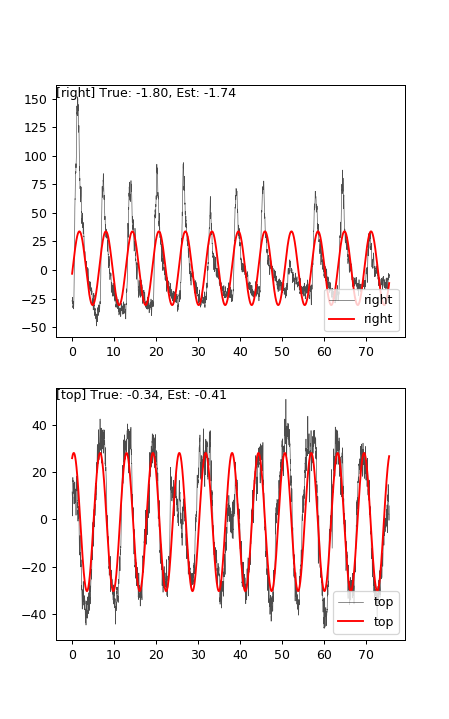

[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom


In [187]:
# Plot single condition first

#rids = [23, 24, 27, 3, 26]
rids = [23, 3]
rcolors = ['r', 'b']
fig, axes = pl.subplots(len(rids), 1, figsize=(5, 8)) # = pl.figure()

for aix, rid in enumerate(rids):
    ax = axes[aix]
    roi_data = pd.concat((pd.Series(data=traces['traces'][cond]['traces'][rid, :], name=cond)\
                          for cond in trials_by_cond.keys()), axis=1)
    roi_phases = pd.DataFrame((pd.Series(data=sp.stats.circmean(phase_array[trialnums].iloc[rid], \
                                                                high=highval, low=lowval), name=cond))\
                              for cond, trialnums in trials_by_cond.items()).T

    roi_fit = fit_roi_trace(roi_data, roi_phases, t, use_cos=use_cos)

    c_best = mean_magratios.iloc[rid][mean_magratios.iloc[rid]==mean_magratios.iloc[rid].max()].index[0]

    # Azimuth conditions:
    maxloc = roi_data[c_best].max()
    data_fit = roi_fit[c_best]['fit']
    
#     ax.plot(roi_fit[c_best]['params']['t'], data_fit, color=rcolors[aix], label=rid)
#     ax.plot(roi_fit[c_best]['params']['t'], roi_data[c_best], color=rcolors[aix], label=rid)

    
    plot_fit_by_condition(roi_fit[c_best], data=roi_data[c_best], t=t, 
                          color='k', fit_color='r', label=c_best, ax=ax, annot_loc=maxloc)


[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom


<IPython.core.display.Javascript object>


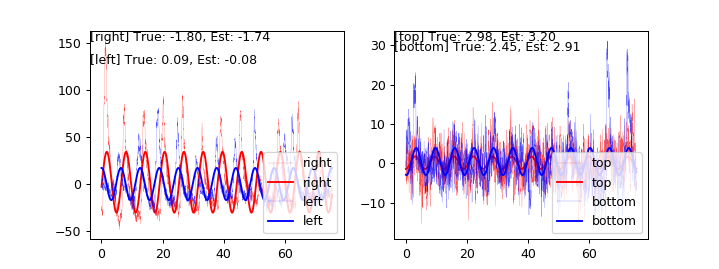

In [159]:
# Now, plot all condition fits:

rid = 23 #14 #best_fits[0]

roi_data = pd.concat((pd.Series(data=traces['traces'][cond]['traces'][rid, :], name=cond)\
                      for cond in trials_by_cond.keys()), axis=1)
roi_phases = pd.DataFrame((pd.Series(data=sp.stats.circmean(phase_array[trialnums].iloc[rid], 
                                                            high=highval, low=lowval), 
                                     name=cond)) for cond, trialnums in trials_by_cond.items()).T

roi_fit = fit_roi_trace(roi_data, roi_phases, t, use_cos=use_cos)

fig, axes = pl.subplots(1, 2, figsize=(8,3)) # = pl.figure()

print ax

# Azimuth conditions:
maxloc = max([roi_data['right'].max(), roi_data['left'].max()])
plot_fit_by_condition(roi_fit['right'], data=roi_data['right'], t=t, 
                      color='r', label='right', ax=axes[0], annot_loc=maxloc)
annot_offset = np.diff(axes[0].get_yticks()).mean() * 0.5
plot_fit_by_condition(roi_fit['left'], data=roi_data['left'], t=t, 
                      color='b', label='left', ax=axes[0],  annot_loc=maxloc-annot_offset) #maxloc-300)

# Elevation conditions:
maxloc = max([roi_data['top'].max(), roi_data['bottom'].max()])
plot_fit_by_condition(roi_fit['top'], data=roi_data['top'], t=t, 
                      color='r', label='top', ax=axes[1], annot_loc=maxloc)
annot_offset = np.diff(axes[1].get_yticks()).mean() * 0.5
plot_fit_by_condition(roi_fit['bottom'], data=roi_data['bottom'], t=t, 
                      color='b', label='bottom', ax=axes[1], annot_loc=maxloc-annot_offset) #maxloc-300)




# Fit all rois

In [ ]:

use_cos= True
fr = stiminfo[condition]['frame_rate']
n_frames = stiminfo[condition]['nframes']
stimfreq = stiminfo[condition]['stimfreq']
frame_period = 1./fr
t_frames = np.arange(frame_period, frame_period * (n_frames+1), frame_period)
print t_frames[0:5]
t = t_frames * (2*np.pi) * stimfreq

In [ ]:
# Make subdir to save each roi's fit:
create_new = False

curr_figdir = os.path.join(roi_fit_dir, 'roi_fits')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)


fit_results_fpath = os.path.join(roi_fit_dir, 'fit_results.pkl')
if os.path.exists(fit_results_fpath) and create_new is False:
    with open(fit_results_fpath, 'rb') as f:
        fit_results = pkl.load(f)
        
else:
    roi_list = copy.copy(best_fits)
    fit_results = fit_traces_by_roi(traces, roi_list, trials_by_cond, )


    with open(fit_results_fpath, 'wb') as f:
        pkl.dump(fit_results, f, protocol=pkl.HIGHEST_PROTOCOL)


#### Compare FIT vs. TRUE (all conditions)


In [ ]:
#true_right = [best_fit_results[rid]['fit_results']['right']['params']['init_phase'] for rid in best_fits]
#est_right = [best_fit_results[rid]['fit_results']['right']['params']['fit_phase'] for rid in best_fits]

fig = pl.figure() #figsize=(10,10))
ax = fig.add_subplot(111)

colors = {'right': 'r', 
          'left': 'm',
          'top': 'b',
          'bottom': 'g'}

for ci, cond in enumerate(conditions): #['right']:
    true_phase = np.array([fit_results[rid]['roi_fit'][cond]['params']['init_phase'] for rid in best_fits])
    fit_phase = np.array([fit_results[rid]['roi_fit'][cond]['params']['fit_phase'] for rid in best_fits])
    
    if not use_corrected:
        corrected_true = vf.correct_phase_wrap(true_phase)
        corrected_est = vf.correct_phase_wrap(fit_phase)
    
    mag = [magratio[trials_by_cond[cond]].iloc[rid].mean() for rid in best_fits]
    
    ax.plot(corrected_true, corrected_est, 'o',alpha=0.5, label=cond, color=colors[cond])

    pl.legend() #loc='center left', bbox_to_anchor=(1, 0.5))
    
    pl.xlabel('true')
    pl.ylabel('est')
    
label_figure(fig, data_identifier)

pl.savefig(os.path.join(roi_fit_dir, 'true_vs_fit_phases_%.2f.png' % fit_thr))


#### Compare dir1 vs. dir2 (FIT)

In [ ]:
def compare_phase_by_axis(fit_results, color1='b', color2='o', use_fit=False, use_corrected=False):

    phase_to_use = 'fit_phase' if use_fit else 'init_phase'
    
    fig = pl.figure(figsize=(10,5))

    #color1 = 'r'
    #color2 = 'b'

    xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
        r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
    xL = xL[::2]

    for ci, (c1, c2) in enumerate([['left', 'right'], ['bottom', 'top']]): #['right']:
        ax = fig.add_subplot(1, 2, ci+1, projection='polar')
        cond1 = np.array([fit_results[rid]['roi_fit'][c1]['params'][phase_to_use] for rid in best_fits])
        cond2 = np.array([fit_results[rid]['roi_fit'][c2]['params'][phase_to_use] for rid in best_fits])

        if not use_corrected:
            cond1 = vf.correct_phase_wrap(cond1)
            cond2 = vf.correct_phase_wrap(cond2)

        mag1 = [magratio[trials_by_cond[c1]].iloc[rid].mean() for rid in best_fits]
        mag2 = [magratio[trials_by_cond[c2]].iloc[rid].mean() for rid in best_fits]

        ax.plot(cond1, mag1, 'o',alpha=0.1, label=c1, color=color1, markersize=10) #[cond])
        ax.plot(cond2, mag2, 'o', alpha=0.1, label=c2, color=color2, markersize=10) 
        ax.annotate("", xy=( sp.stats.circmean(cond1, high=highval, low=lowval), np.mean(mag1)), xytext=(0, 0), 
                    arrowprops=dict(arrowstyle="-", edgecolor=color1, linewidth=3))
        ax.annotate("", xy=( sp.stats.circmean(cond2, high=highval, low=lowval), np.mean(mag2)), xytext=(0, 0), 
                    arrowprops=dict(arrowstyle="-", edgecolor=color2, linewidth=3))

        ax.set_theta_offset(np.pi/2) 
        pl.legend(loc='center left', bbox_to_anchor=(0.8, 0))

        xT = pl.xticks()[0][0::2]
        pl.xticks(xT, xL)
    
    return fig

In [ ]:
c1_color = 'b'
c2_color = 'orange'

# Plot found FIT phases for all included rois in fit_results:
use_fit = True
fig = compare_phase_by_axis(fit_results, color1=c1_color, color2=c2_color, use_fit=use_fit, use_corrected=use_corrected)
fig_title = 'least-sq fit' if use_fit else 'data'
fig.suptitle(fig_title)
label_figure(fig, data_identifier)
figname = 'polar_compare_directions_lstsqfit_%.2f' % fit_thr
pl.savefig(os.path.join(roi_fit_dir, '%s.png' % figname))
print roi_fit_dir
print figname

# Plot found MEASURED phases for all included rois in fit_results:
use_fit = False
fig = compare_phase_by_axis(fit_results, color1=c1_color, color2=c2_color, use_fit=use_fit, use_corrected=use_corrected)
fig_title = 'least-sq fit' if use_fit else 'data'
fig.suptitle(fig_title)
label_figure(fig, data_identifier)
figname = 'polar_compare_directions_measured_%.2f' % fit_thr
pl.savefig(os.path.join(roi_fit_dir, '%s.png' % figname))
print roi_fit_dir
print figname

#### Visualize difference in phase between fit and true

In [ ]:
#### Look at histogram of diff between fit and true:

#fig, axes = pl.subplots(2,2)
fig = pl.figure(figsize=(10,5))

fit_diffs = {}
#for ax, cond in zip(axes.flat, conditions):
for ci, cond in enumerate(['left', 'bottom', 'right', 'top']):
    col_ix = 0 if cond in ['left', 'right'] else 1
    row_ix = 0 if cond in ['left', 'bottom'] else 1
    ax = pl.subplot2grid((2,4), (row_ix, col_ix))
    fit_vals = np.squeeze(np.array([fit_results[rid]['roi_fit'][cond]['params']['fit_phase'] for rid in best_fits]))
    true_vals = np.squeeze(np.array([fit_results[rid]['roi_fit'][cond]['params']['init_phase'] for rid in best_fits]))
    
#     if not use_corrected:
#         fit_vals = np.array([float(v) for v in vf.correct_phase_wrap(fit_vals)])
#         true_vals = np.array([float(v) for v in vf.correct_phase_wrap(true_vals)])
        
    diffs = np.abs(fit_vals - true_vals)
    sns.distplot(diffs, ax=ax, kde=False, bins=len(best_fits)/2)
    ax.set_title(cond)
    fit_diffs[cond] = diffs
    ax.set_xlim([0, np.pi])

sns.despine(trim=True, offset=8)

ax = pl.subplot2grid((2, 4), (0, 2), colspan=2, rowspan=2)
all_diffs = [l for sublist in [vals for cond, vals in fit_diffs.items()] for l in sublist]
sns.distplot(all_diffs, kde=False, bins=len(best_fits), ax=ax)
sns.despine(bottom=False, offset=8)
ax.set_xlim([0, np.pi])
ax.set_title('fit - true (all condNs)')

fig.subplots_adjust(hspace=0.5, wspace=0.5)

label_figure(fig, data_identifier)
figname = 'hist_diff_bw_fit_and_measured_by_cond_%.2f' % fit_thr
pl.savefig(os.path.join(roi_fit_dir, '%s.png' % figname))
print figname

#### Visualize phase offset between opposing directions


In [ ]:
# TRUE data -- Look at diff between opposite dirs:

def compare_phase_diff_by_axis(fit_results, best_fits, use_fit=False):
    
    phase_type = 'fit_phase' if use_fit else 'init_phase'
    cond1 = np.squeeze(np.array([fit_results[rid]['roi_fit']['left']['params'][phase_type] for rid in best_fits]))
    cond2 = np.squeeze(np.array([fit_results[rid]['roi_fit']['right']['params'][phase_type] for rid in best_fits]))

    if not use_corrected:
        cond1 = vf.correct_phase_wrap(cond1)
        cond2 = vf.correct_phase_wrap(cond2)
    diffs_az = np.abs(cond1-cond2)

    cond1 = np.squeeze(np.array([fit_results[rid]['roi_fit']['bottom']['params'][phase_type] for rid in best_fits]))
    cond2 = np.squeeze(np.array([fit_results[rid]['roi_fit']['top']['params'][phase_type] for rid in best_fits]))

    if not use_corrected:
        cond1 = vf.correct_phase_wrap(cond1)
        cond2 = vf.correct_phase_wrap(cond2)
    diffs_el = np.abs(cond1 - cond2)

    fig, axes = pl.subplots(1,2) #pl.figure()
    sns.distplot(diffs_az, kde=False,bins=20, ax=axes[0])
    axes[0].set_xlim([0, 2*np.pi])
    axes[0].set_title('azimuth')
    axes[0].text(axes[0].get_xlim()[0], 0.5, 'min: %.2f\nmax: %.2f' % (diffs_az.min(), diffs_az.max()))

    sns.distplot(diffs_el, kde=False,bins=20, ax=axes[1])
    axes[1].set_xlim([0, 2*np.pi])
    axes[1].set_title('elevation')
    axes[1].text(axes[1].get_xlim()[0], 0.5, 'min: %.2f\nmax: %.2f' % (diffs_el.min(), diffs_el.max()))

    sns.despine(offset=8, trim=True)
    
    pl.subplots_adjust(top=0.8)
    
    return fig


In [ ]:
# FIT data:  Look at diff between opposite dirs:

use_fit = True
fig = compare_phase_diff_by_axis(fit_results, best_fits, use_fit=use_fit)
label_figure(fig, data_identifier)
fig_str = 'lstsqfit' if use_fit else 'measured'
fig.suptitle(fig_str)
figname = 'hist_%s_diff_bw_azimuth_altitude_%.2f' % (fig_str, fit_thr)
pl.savefig(os.path.join(roi_fit_dir, '%s.png' % figname))
print figname

use_fit = False
fig = compare_phase_diff_by_axis(fit_results, best_fits, use_fit=use_fit)
label_figure(fig, data_identifier)
fig_str = 'lstsqfit' if use_fit else 'measured'
fig.suptitle(fig_str)
figname = 'hist_%s_diff_bw_azimuth_altitude_%.2f' % (fig_str, fit_thr)
pl.savefig(os.path.join(roi_fit_dir, '%s.png' % figname))
print figname